# Problem Statement: Bias Variance Decomposition using synthetic data

Importing necessary Libraries


In [ ]:
import numpy as np
import matplotlib.pyplot as plt 
import sys
import matplotlib
from numpy.matlib import repmat
import time
import scipy 
from scipy.io import loadmat
%matplotlib inline 

We will now create a data set for which we can approximately compute this decomposition. The function `toydata` generates a binary data set with class 1 and 2.

toydata is a helper function which creates a binary data with n/2 values in class 1 and n/2 values in class 2. With class 1 being the label for data drawn from a normal distribution having mean 0 and sigma 1. And class 2 being the label for data drawn from a normal distribution with mean as the offset and sigma 1.

In [ ]:
def toydata(offset,n):
  """
  f[x,y]=toydata(OFFSET,N)
    
    This function constructs a binary data set. 
    Each class is distributed by a standard Gaussian distribution.
    'nh' is giving us the two parts of 'n' 
    'a' giving us the dataset
  """

  a = np.random.randn(n,2)
  nh = int(np.ceil(n/2))
  a[nh: ,:] += offset

  y = np.ones(n)
  y[nh: ] *= 2
  m = np.random.permutation(n)
  return a[m, :],y[m]

In order to focus on noise , we need to compute ybar(x) in **computeybar** 

In [ ]:
def computeybar(x,offset):
  """
   f[ybar]=computeybar(x, OFFSET);

    computes the expected label 'ybar' for a set of inputs x
    generated from two standard Normal distributions
    m , s are normal distibution parameters
    'x' is the array of 2D vectors
    'ybar' is the vector of expected outputs for x
  """
  n, t = x.shape
  yb = np.zeros(n)

  ndist = lambda a , m , s : np.exp(-0.5 * np.power((a-m)/ s, 2)) / (np.sqrt(2 * np.pi)*s)

  d1 = ndist(x,0,1)
  d11 = d1[:,0]*d1[:,1]
  d2 = ndist(x,offset,1)
  d22 = d2[:,0]*d2[:,1]

  dm = (d11+d22)/2

  dy1 = d11*0.5/dm
  dy2 = d22*0.5/dm

  yb = dy1 + 2*dy2

  return yb



Visualizing the Data with the bayes classifier. We can see in the plotting of the two classes of points 

7.5 % Error


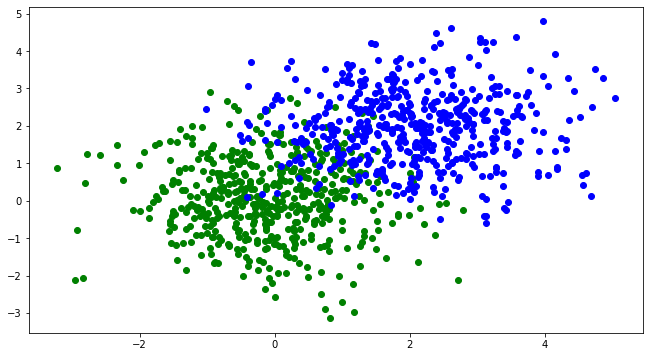

In [ ]:
offset = 2

x , y = toydata(offset,1000)

ybar = computeybar(x,offset)
pred = np.round(ybar)
error = pred != y

err = error.sum() /len(y) *100
print(err , "% Error")

a1 = y == 1
a2 = y == 2
plt.figure(figsize = (11,6))
plt.scatter(x[a1,0] , x[a1,1], c = 'g' , marker = 'o')
plt.scatter(x[a2,0] , x[a2,1], c = 'b', marker = 'o')
plt.show()

distance is a helper function used in our implementation of the ridge regression.

In [ ]:
def distance(x, z= None):

  """
  D = distance(x,z)

    It Computes the Euclidean distance matrix.
    'x' is a matrix of n*d , n being the column vectors 
    'z' is a matrix of m*d , m being the column vectors
  """

  if z is None:
    n , d = x.shape
    dd = -2*np.dot(x,x.T) + repmat(ss,1,n)
    ss = np.sum(np.power(x,2), axis=1).reshape(-1,1)
    d = dd + repmat(ss.T,n,1)
    np.fill_diagonals(d,0)

    d = np.sqrt(np.maximum(d,0))

  else:
    n , d = x.shape
    m , _ = z.shape
    st = np.sum(np.power(z,2), axis=1).reshape(1,-1)
    ss = np.sum(np.power(x,2), axis=1).reshape(-1,1)

    dd = -2*np.dot(x,z.T) + repmat(ss,1,m)
    d = dd + repmat(st,n,1)
    d = np.sqrt(np.maximum(d,0))

  return d



In order to calculate bias and hbar , we need to use a model to get outputs from the given data , here we use ridge regression (kernelized) with kernel width sigma and regularization constant lambda

In [ ]:
def ridgereg(xtr,ytr,sigma = 0.1,l = 0.01):
  """
    function ridgereg(xTr,yTr,sigma,l)
    
    l is lambda , regularization constant
    xTr is the training data 
    yTr are the training labels 
    sigma is the kernel width (>0)
    
    function gives us the predictions from the data 
  """

  k = lambda x, z: np.power(1+(np.power(distance(x,z),2)/(2*np.power(sigma,2))),-4)
  ridge = lambda k , l2 :k + l *np.eye(k.shape[0],k.shape[1])

  ans = np.linalg.solve(ridge(k(xtr,xtr),l),ytr)

  function = lambda xt : np.dot(k(xt,xtr),ans)
  return function


**Bias** , In order to calculate the bias , we need hbar , the expected output from the model , but  we can approximate it by training many models of the same and averaging their predictions.
Here we train using different sub samples of the data from the same distribution 

In [ ]:
def computehbar(x,s,l,n,models,offset):
  """
    function computehbar(x, sigma, lmbda, small'n', no. of models, OFFSET);

    computes the expected prediction for the given data by averaging . 
    we know x , s , l being the data , sigma and lambda , used for ridge regression model
    n being the sub sample of data used

    hbar being the average of prediction outputs for each test input
    Now we can calculate the Bias
  """

  nn = x.shape[0]
  hbar = np.zeros(nn)

  for i in range(models):
    xt , yt = toydata(offset,n)
    model = ridgereg(xt,yt,s,l)
    hbar += model(x)

  hbar /= models

  return hbar

**Variance** , Now finally we can compute the predicted value minus the expected value and to calculate the expectation of this outcome , we average over the variances for different model outputs

In [ ]:
def computevariance(x,s,l,hbar,n,models,offset):
  """
    function computevariance(x,sigma,lmbda,hbar,small'n',no of models,OFFSET)

    computes the variance of classifiers trained on data sets and the averages over them to get the expectation
    with ridge regression with sigma and lmbda
     
    the prediction of the average classifier is taken as values stored in hbar.

    """
    

  nn = x.shape[0]
  variance = np.zeros(nn)

  for i in range(models):

    xtr , ytr = toydata(offset,n)
    model = ridgereg(xtr,ytr,s,l)
    variance += (model(x)-hbar)**2

  variance = np.mean(variance)/models
  return variance

## Now that we have calculated ybar , hbar and variance using the above functions , we can execute the Demo and thus see that how the error decomposes (roughly) into bias, variance and noise when regularization constant λ increases.

In [ ]:
ns = 10
nb = 10000

models = 100

l = np.arange(-6,0+0.5,0.5)

s = 4

nl = len(l)
lbias = np.zeros(nl)
lvariance = np.zeros(nl)
ltotal = np.zeros(nl)
lnoise = np.zeros(nl)
lsum = np.zeros(nl)
#here we use different lambdas (regularization constants for classifiers)
for m in range(nl):
  lm = 2**l[m]

  xt , yt = toydata(offset,nb)

  total = 0

  for i in range(models):
    xt2 ,yt2 = toydata(offset,ns)
    fsm = ridgereg(xt2,yt2,s,lm)
    total += np.mean((fsm(xt)-yt)**2)

  total = total/models
  # Noise esitimation 
  ybar = computeybar(xt,offset)
  noise = np.mean((yt-ybar)**2)

  # Bias estimation 
  hbar = computehbar(xt,s,lm,ns,models,offset)
  bias = np.mean((hbar-ybar)**2)

  # Variance estimation 
  variance = computevariance(xt,s,lm,hbar,ns,models,offset)

  lbias[m] = bias
  lvariance[m] = variance
  ltotal[m] = total
  lnoise[m] = noise
  lsum[m] =  lvariance[m] + lbias[m] + lnoise[m]
  print( "Variance = ",lvariance[m], " Bias = ", lbias[m], " Noise = ",lnoise[m], " Total = ",lsum[m] , " Test Error = ", ltotal[m] )

Variance =  0.07758984458889796  Bias =  0.02516997501726676  Noise =  0.05642559159605332  Total =  0.15918541120221805  Test Error =  0.16833761404302458
Variance =  0.07070928996772964  Bias =  0.03158903758737835  Noise =  0.06116211193278158  Total =  0.16346043948788958  Test Error =  0.16339895156320886
Variance =  0.06081551003139399  Bias =  0.03218190958889351  Noise =  0.05790663278744675  Total =  0.15090405240773425  Test Error =  0.14921310872769752
Variance =  0.05287790975037319  Bias =  0.03055785596258336  Noise =  0.057577759196476896  Total =  0.14101352490943345  Test Error =  0.1382143816469759
Variance =  0.04618725951986149  Bias =  0.03279655439628842  Noise =  0.05725306557660416  Total =  0.13623687949275406  Test Error =  0.13615768778525653
Variance =  0.04288219314447837  Bias =  0.03800508588880912  Noise =  0.05709818756684306  Total =  0.13798546660013056  Test Error =  0.13429135918016522
Variance =  0.03946617858266028  Bias =  0.0455468456909031  Noi

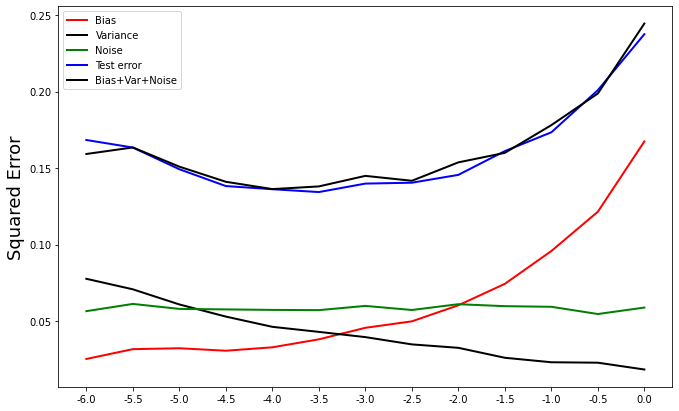

In [ ]:
plt.figure(figsize=(11,7))
plt.plot(lbias[:nl],c='r',linestyle='-',linewidth=2)
plt.plot(lnoise[:nl],c='g', linestyle='-',linewidth=2)
plt.plot(ltotal[:nl],c='b', linestyle='-',linewidth=2)
plt.plot(lvariance[:nl],c='k', linestyle='-',linewidth=2)
plt.plot(lsum[:nl],c='k', linestyle='-',linewidth=2)

plt.legend(["Bias","Variance","Noise","Test error","Bias+Var+Noise"]);
plt.ylabel("Squared Error",fontsize=18);
plt.xticks([i for i in range(nl)],l);


## We can conclude that the bigger number for the number of models and/or the training dataset, the better your approximation could be.